<a href="https://colab.research.google.com/github/hollen789/U-Net-Brain-Tumor-Detection/blob/main/COMP3106_finalproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Brain Tumor Detection






## Introduction
Brain tumors present significant challenges in the medical field, not only due to their complex nature
but also because of their profound impact on patient survival and quality of life. Accurate segmentation
of brain tumors from MRI scans is crucial for diagnosis, treatment planning, and monitoring disease
progression.

Traditionally, deep learning models like U-Net have been employed for this purpose,
achieving remarkable results in segmenting various tumor regions.
However, beyond segmentation, predicting patient survival based on imaging and clinical data is
equally vital. Survival prediction aids clinicians in tailoring treatment strategies, managing patient
expectations, and allocating medical resources efficiently. While segmentation provides spatial
information about the tumor, survival prediction synthesizes this with patient demographics and clinical
factors to forecast outcomes.



##Objectives

The primary objective of this project was to transition from an image segmentation task using U-Net to
a survival prediction task utilizing classical machine learning models. This involved extracting
meaningful features from MRI scans and patient data, preprocessing these features, and applying
various machine learning classifiers to predict patient survival categories. Additionally, the project
aimed to evaluate and compare the performance of these classifiers, identify the most significant
features influencing survival, and discuss the implications and limitations of the findings.

## Procedures

- Set up environment + dataset
- Data exploration
- Prepare data for Training
- Define the model
- Train the model
- Predict tumor segmentations
- Evaluate the model

### Set up environment + Downloading dataset

In [ ]:
!pip install -r requirements.txt

###importing the librairies

In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random

from tensorflow import keras
from keras.layers import *
from keras.models import *

# from tensorflow.keras.layers import *
# from tensorflow.keras.models import *



import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

### Downloading the BraTS2020 Dataset using Kaggle


create a new hidden folder ".kaggle":

In [ ]:
!mkdir -p ~/.kaggle

move the downloaded file to this new folder:

In [ ]:
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

set the Kaggle API key :

In [ ]:
!kaggle config set -n apikey -v ~/.kaggle/kaggle.json

- apikey is now set to: /root/.kaggle/kaggle.json


download the BraTS2020 Dataset:

In [ ]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.15G/4.16G [00:57<00:00, 184MB/s]
100% 4.16G/4.16G [00:58<00:00, 76.9MB/s]


you should get the zip file:

"brats20-dataset-training-validation.zip".

we unzip it:

In [ ]:
# Unzip dataset
path_to_zip_file = "brats20-dataset-training-validation.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

We fix a file that has an inconsistent name inside the dataset:

In [ ]:
# Absolute path of the incorrectly named file
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

Maybe you have already renamed the file or the file is not misspelled on the dataset anymore


### Modalities & Segmentation

Each sample includes 4 different types of MRI scans of the patient's brain, also known as modalities:

1) T1

2) T1ce

3) T2

4) FLAIR

Here are some graphical representations of each modality:

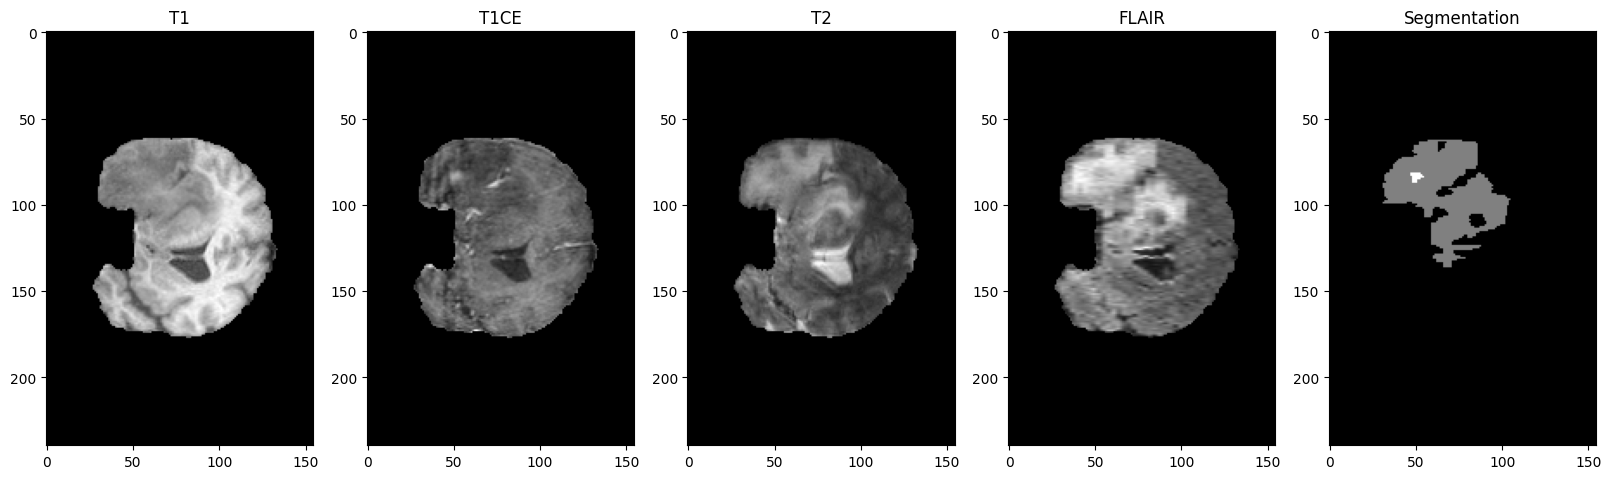

In [ ]:
sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Loading the 4 MRI modalities and the segmentation
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,slice_nb,:], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,slice_nb,:], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,slice_nb,:], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,slice_nb,:], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,slice_nb,:], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

As you can see, the two modalities we will be focusing on is:

- **Post-contrast T1ce:** Similar to T1 images but with the injection of a contrast agent which enhances the visibility of abnormalities(such as tumors).

- **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery) :** Used to suppress this fluid content. useful for detecting lesions that weren't clearly visible on the other modalities

In practice, all four modalities would be scanned and analyzed during diagnoses, but in our case we will only be analyzing T1ce and FLAIR as they are:

- more depth in what we're looking for and they also provide more possible diagnoses for a patient than the other modalities

- helps in task efficiency and making the information less bloated

#### Images format

In [ ]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


We are given these 3 planes:
- **Sagittal Plane**: Divides the body into left and right sections, considered the "front-back" plane.

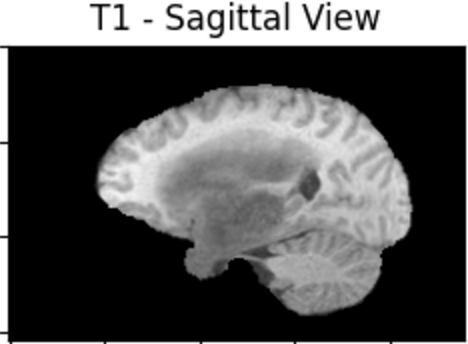

- **Coronal Plane**: Divides the body into front and back sections, considered the "side-side" plane.
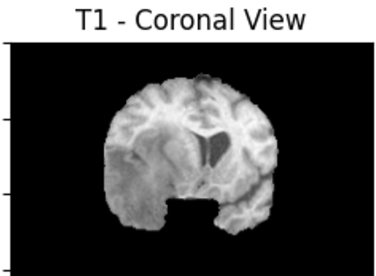
- **Axial**: Divides the body into top and bottom, considered the "head-toe" plane.
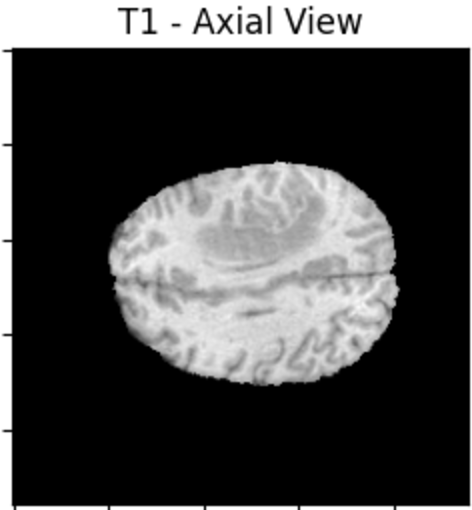

here, we will display 100 of these slices:

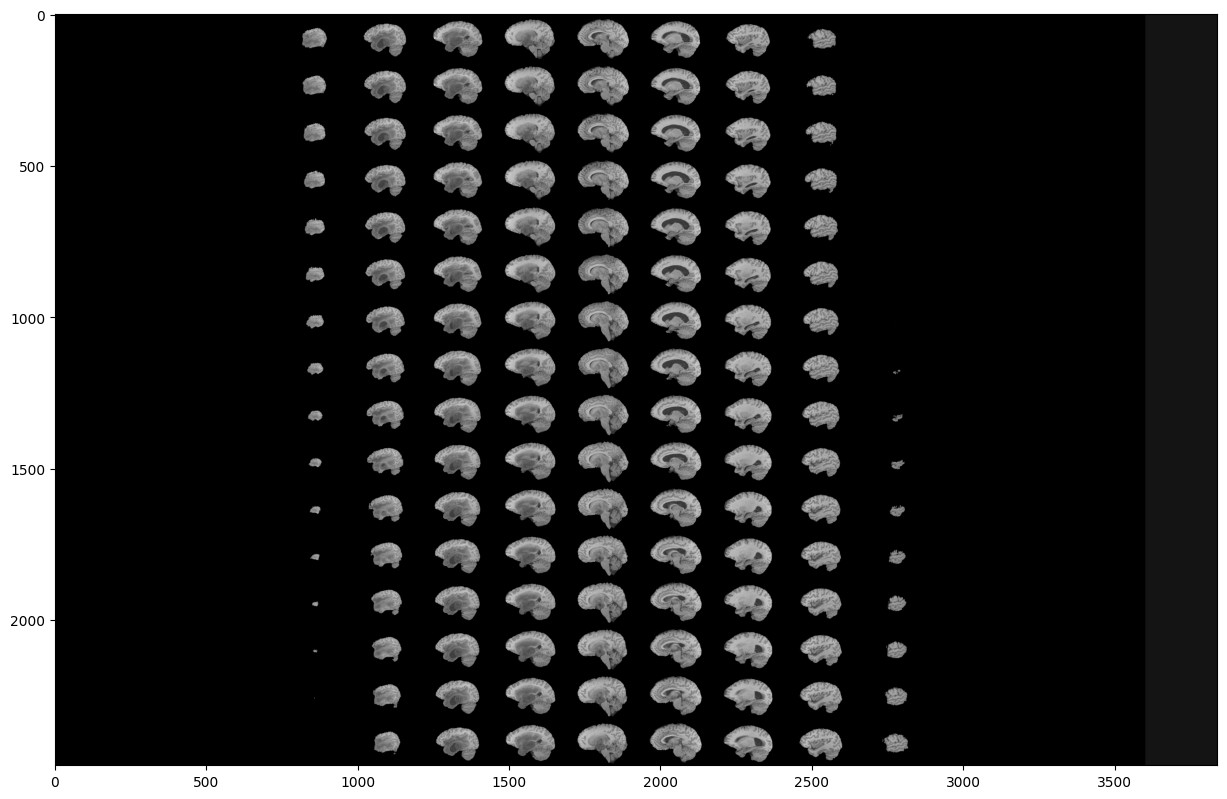

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

we see that a majority of the segments don't not contain much information(black parts of the plot), as the mass of the brain reaches an apex at the center of the scan, we can surmise this pattern follows for all other modalities. So in order to make our data more concise and efficient, we will limit our range of segmentations to (80:120), as they contain much more useful information:

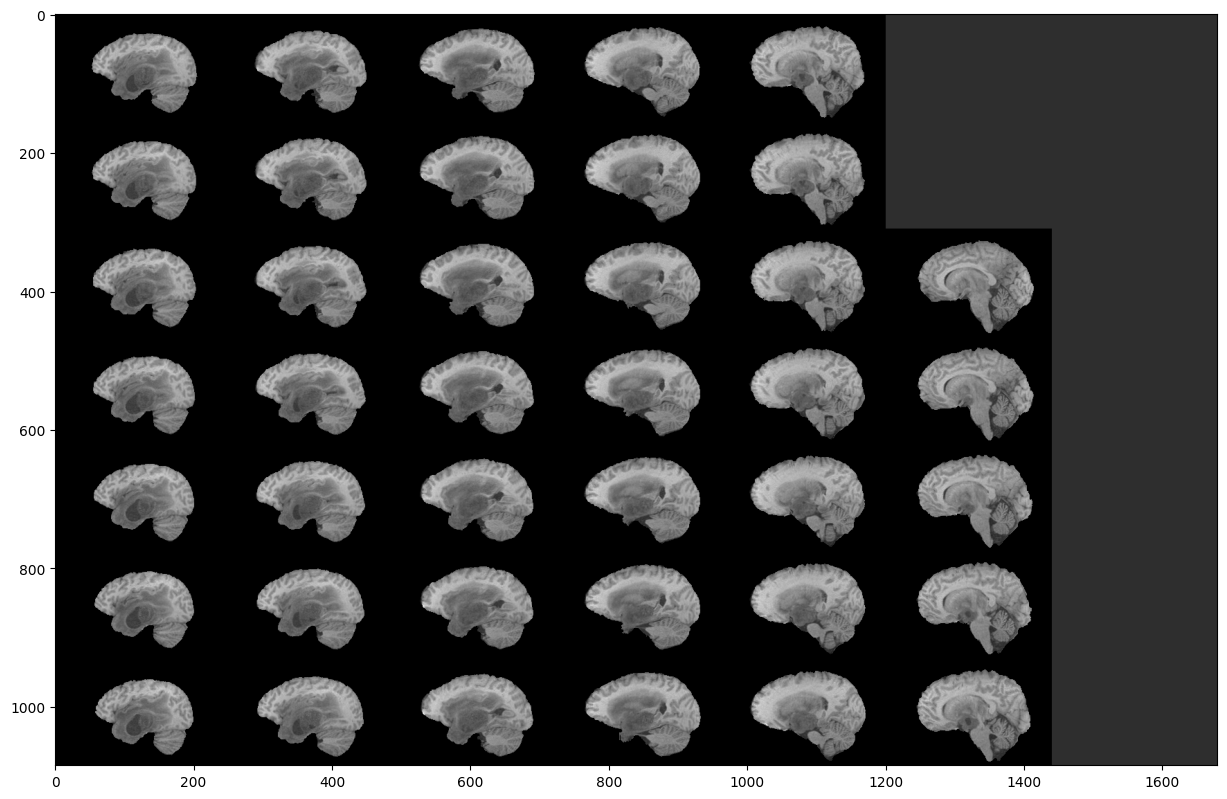

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[80:120,:,:]), 90, resize=True), cmap ='gray')

###Tumor Classifications:
here, we have the different classifications of the segments via color

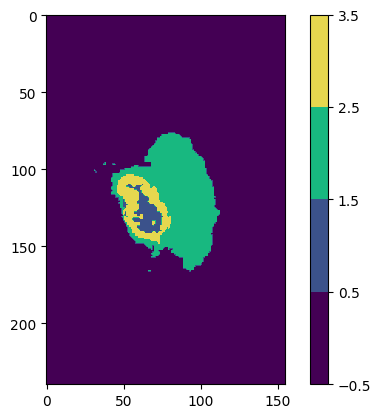

In [ ]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()


Here are the values assigned to each color, every segmentation image will contain these values:

In [ ]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Values: {saved_values}")

Values: [0. 1. 2. 4.]


We have 4 possible values in the segmentation files. each corresponding to these classes:

- 0 (purple): Not Tumor (NT) which means Healthy Zone or Background
- 1 (blue): Necrotic and Non-Enhancing Tumor (NCR + NET)
- 2 (green): Peritumoral Edema (ED)
- 4 (yellow): Enhancing Tumor (ET)
class 4 is mislabled as it should be class 3, this will be changed later


Here are the distribution of these 4 values throughout the images:

In [ ]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


This is the range (80:120) that will be used later for our model:

In [ ]:
# Define selected slices range
VOLUME_START_AT = 80
VOLUME_SLICES = 40

### Prepare Data For Training

the data is split into three sets:

- Training set
- Validation set
- Test set

Most if not all processes was sourced from: https://www.kaggle.com/code/rastislav/mri-brain-tumor-survival-prediction#Computing-segment-sizes

In [ ]:
# Specify path of our BraTS2020 directory
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
#Remove junk files
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

###Initialize sets:

In [ ]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


## Create a DataGenerator
source from: https://www.kaggle.com/code/rastislav/mri-brain-tumor-survival-prediction#Computing-segment-sizes

This data generator prepares the batches for the training process, This would save in the memory-efficency as the alternative would be loading the entire dataset

###The following parameters were set for the class:
- list_IDs: A list of patient identifiers used to locate their data.
- dim: The dimensions of the images after resizing (defaults to IMG_SIZE x IMG_SIZE, which is 64x64).
- batch_size: The number of samples to load and process in each batch (defaults to 1).
- n_channels: The number of image channels (defaults to 2, likely for T1CE and FLAIR modalities).
- shuffle: Whether to shuffle the order of the data at the end of each epoch (defaults to True).
It also calls self.on_epoch_end() to set up initial data indices.
###The following steps were made:
- work in Axial plane
- One-Hot encoding
- Resizing slice of images from (240x240) to (128x128)

In [ ]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 64

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

### Define the model

Now that we can iterate on our data, we can define our segmentation model:

## U-Net

source from:
https://www.kaggle.com/code/rastislav/mri-brain-tumor-survival-prediction#Computing-segment-sizes

Since the BraTS2020 dataset consists of 3D images with correlating 2D slices in the three planes, we can either implement a 2D or a 3D U-Net.

We will implement a 2D U-Net as it is more computationally faster and more spatially efficient than a 3D U-Net, which can help mediate with working under large datasets.

In practice, both U-Net architectures would be used to get a better scope of the diagnosis.

In [ ]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

#### Loss function:
We used categorical cross-entropy for this model, which is commonly used for its robustness and optimization of the gradient descent. Note that most medical applications(such as this one) would apply dice loss as it better handles class imbalance and promotes spatial continuity, in this case, it could be very impactful for brain tumor segmentations.

#### Output activation function:
softmax activation was used to the output layer of our neural network, helps normalize output and minimize loss by comparing with ground truth data

#### Other metrics:

These metrics were used to monitor the model's performance during training:

- Precision: Measures the proportion of predicted positive pixels that are actually positive.

- Sensitivity: Measures the proportion of positive ground truth pixels that were correctly predicted as positive.

- Specificity: Measures the proportion of negative ground truth pixels that were correctly predicted as negative.


In [ ]:
# Compute metric between the predicted segmentation and the ground truth
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

#### Build the model
we would also keep track of the **Accuracy** and **MeanIoU**(the mean overlap between the predicted and ground truth segmentations) during training



In [ ]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), precision, sensitivity, specificity] )

#### Callbacks

functions that are executed during the training process.

We will use these callbacks:

- ReduceLROnPlateau: akin to a lr-scheduler, reduces the learning rate when a metric has stopped improving. The learning rate is reduced by a factor of 0.2,  patience is 2 epochs, and the minimum learning rate is 0.000001.

- ModelCheckpoint: Saves the best model weights which can be reloaded later(skips inadequate epochs)

-  CSVLogger: records metrics to a CSV file(training.log), for analysis purposes.

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

### Train/Save the model

We will now train the model with epoch of 10 for the sake of time, it will still take quite a bit, so we saved our epochs so you can just reload it back into the model.

In [ ]:
model.fit(training_generator,
          epochs=10,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

### Output recieved
### For the sake of time, this is the epochs we recieved

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9782 - mean_io_u: 0.6345 - precision: 0.9803 - sensitivity: 0.9754 - specificity: 0.9935
Epoch 1: val_loss improved from 0.09669 to 0.07069, saving model to model_.01-0.070692.m5
250/250 [==============================] - 1956s 8s/step - loss: 0.0854 - accuracy: 0.9782 - mean_io_u: 0.6345 - precision: 0.9803 - sensitivity: 0.9754 - specificity: 0.9935 - val_loss: 0.0707 - val_accuracy: 0.9810 - val_mean_io_u: 0.7622 - val_precision: 0.9824 - val_sensitivity: 0.9801 - val_specificity: 0.9942 - lr: 0.0010

Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9793 - mean_io_u: 0.6395 - precision: 0.9823 - sensitivity: 0.9762 - specificity: 0.9941
Epoch 2: val_loss improved from 0.07069 to 0.05656, saving model to model_.02-0.056557.m5
250/250 [==============================] - 1900s 8s/step - loss: 0.0783 - accuracy: 0.9793 - mean_io_u: 0.6395 - precision: 0.9823 - sensitivity: 0.9762 - specificity: 0.9941 - val_loss: 0.0566 - val_accuracy: 0.9831 - val_mean_io_u: 0.6650 - val_precision: 0.9854 - val_sensitivity: 0.9806 - val_specificity: 0.9952 - lr: 0.0010

Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9816 - mean_io_u: 0.6342 - precision: 0.9854 - sensitivity: 0.9774 - specificity: 0.9951
Epoch 3: val_loss improved from 0.05656 to 0.05149, saving model to model_.03-0.051485.m5
250/250 [==============================] - 1868s 7s/step - loss: 0.0669 - accuracy: 0.9816 - mean_io_u: 0.6342 - precision: 0.9854 - sensitivity: 0.9774 - specificity: 0.9951 - val_loss: 0.0515 - val_accuracy: 0.9845 - val_mean_io_u: 0.6277 - val_precision: 0.9885 - val_sensitivity: 0.9806 - val_specificity: 0.9962 - lr: 0.0010

Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9826 - mean_io_u: 0.6593 - precision: 0.9868 - sensitivity: 0.9785 - specificity: 0.9956
Epoch 4: val_loss did not improve from 0.05149
250/250 [==============================] - 1884s 8s/step - loss: 0.0579 - accuracy: 0.9826 - mean_io_u: 0.6593 - precision: 0.9868 - sensitivity: 0.9785 - specificity: 0.9956 - val_loss: 0.0556 - val_accuracy: 0.9848 - val_mean_io_u: 0.6791 - val_precision: 0.9879 - val_sensitivity: 0.9813 - val_specificity: 0.9959 - lr: 0.0010

Epoch 5/10
250/250 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9829 - mean_io_u: 0.6139 - precision: 0.9872 - sensitivity: 0.9787 - specificity: 0.9957
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5: val_loss did not improve from 0.05149
250/250 [==============================] - 1881s 8s/step - loss: 0.0564 - accuracy: 0.9829 - mean_io_u: 0.6139 - precision: 0.9872 - sensitivity: 0.9787 - specificity: 0.9957 - val_loss: 0.0554 - val_accuracy: 0.9850 - val_mean_io_u: 0.7148 - val_precision: 0.9895 - val_sensitivity: 0.9803 - val_specificity: 0.9964 - lr: 0.0010

Epoch 6/10
250/250 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9852 - mean_io_u: 0.6365 - precision: 0.9903 - sensitivity: 0.9799 - specificity: 0.9967
Epoch 6: val_loss improved from 0.05149 to 0.03550, saving model to model_.06-0.035503.m5
250/250 [==============================] - 1870s 7s/step - loss: 0.0448 - accuracy: 0.9852 - mean_io_u: 0.6365 - precision: 0.9903 - sensitivity: 0.9799 - specificity: 0.9967 - val_loss: 0.0355 - val_accuracy: 0.9880 - val_mean_io_u: 0.6455 - val_precision: 0.9916 - val_sensitivity: 0.9839 - val_specificity: 0.9971 - lr: 2.0000e-04

Epoch 7/10
250/250 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9863 - mean_io_u: 0.6393 - precision: 0.9905 - sensitivity: 0.9819 - specificity: 0.9968
Epoch 7: val_loss improved from 0.03550 to 0.03396, saving model to model_.07-0.033964.m5
250/250 [==============================] - 1845s 7s/step - loss: 0.0399 - accuracy: 0.9863 - mean_io_u: 0.6393 - precision: 0.9905 - sensitivity: 0.9819 - specificity: 0.9968 - val_loss: 0.0340 - val_accuracy: 0.9886 - val_mean_io_u: 0.6361 - val_precision: 0.9927 - val_sensitivity: 0.9839 - val_specificity: 0.9975 - lr: 2.0000e-04

Epoch 8/10
250/250 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9867 - mean_io_u: 0.6520 - precision: 0.9906 - sensitivity: 0.9827 - specificity: 0.9968
Epoch 8: val_loss improved from 0.03396 to 0.03335, saving model to model_.08-0.033349.m5
250/250 [==============================] - 1831s 7s/step - loss: 0.0380 - accuracy: 0.9867 - mean_io_u: 0.6520 - precision: 0.9906 - sensitivity: 0.9827 - specificity: 0.9968 - val_loss: 0.0333 - val_accuracy: 0.9884 - val_mean_io_u: 0.6599 - val_precision: 0.9912 - val_sensitivity: 0.9851 - val_specificity: 0.9970 - lr: 2.0000e-04

Epoch 9/10
250/250 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9873 - mean_io_u: 0.6694 - precision: 0.9907 - sensitivity: 0.9834 - specificity: 0.9968
Epoch 9: val_loss improved from 0.03335 to 0.03094, saving model to model_.09-0.030935.m5
250/250 [==============================] - 1836s 7s/step - loss: 0.0363 - accuracy: 0.9873 - mean_io_u: 0.6694 - precision: 0.9907 - sensitivity: 0.9834 - specificity: 0.9968 - val_loss: 0.0309 - val_accuracy: 0.9893 - val_mean_io_u: 0.6700 - val_precision: 0.9923 - val_sensitivity: 0.9857 - val_specificity: 0.9974 - lr: 2.0000e-04

Epoch 10/10
250/250 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9877 - mean_io_u: 0.6565 - precision: 0.9909 - sensitivity: 0.9840 - specificity: 0.9969
Epoch 10: val_loss did not improve from 0.03094
250/250 [==============================] - 1901s 8s/step - loss: 0.0349 - accuracy: 0.9877 - mean_io_u: 0.6565 - precision: 0.9909 - sensitivity: 0.9840 - specificity: 0.9969 - val_loss: 0.0311 - val_accuracy: 0.9894 - val_mean_io_u: 0.6615 - val_precision: 0.9924 - val_sensitivity: 0.9856 - val_specificity: 0.9974 - lr: 2.0000e-04

<keras.callbacks.History at 0x7bd15036e440>



###Reload model
**We have a downloaded the weights of each epoch(that improved val_los), you can simply put it in the files for google colab to use the model**

In [ ]:
model.load_weights('model_.01-0.070692.m5')
model.load_weights('model_.01-0.096691.m5')
model.load_weights('model_.02-0.056557.m5')
model.load_weights('model_.03-0.051485.m5')
model.load_weights('model_.06-0.035503.m5')
model.load_weights('model_.07-0.033964.m5')
model.load_weights('model_.08-0.033349.m5')
model.load_weights('model_.09-0.030935.m5')

NameError: name 'model' is not defined

### Metrics analysis

We call CSVLogger to get a better see the training process and  performance of our model(This requires the model to be retrained, model.load_weights() doesn't track this so we have to call model.fit())

In [ ]:
# Read the CSVlogger file with our metrics
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[2].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Mean IOU')
axs[2].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'training.log'

###Sample Table: (These were tables from another trained model but we will assume the patterns are similar)

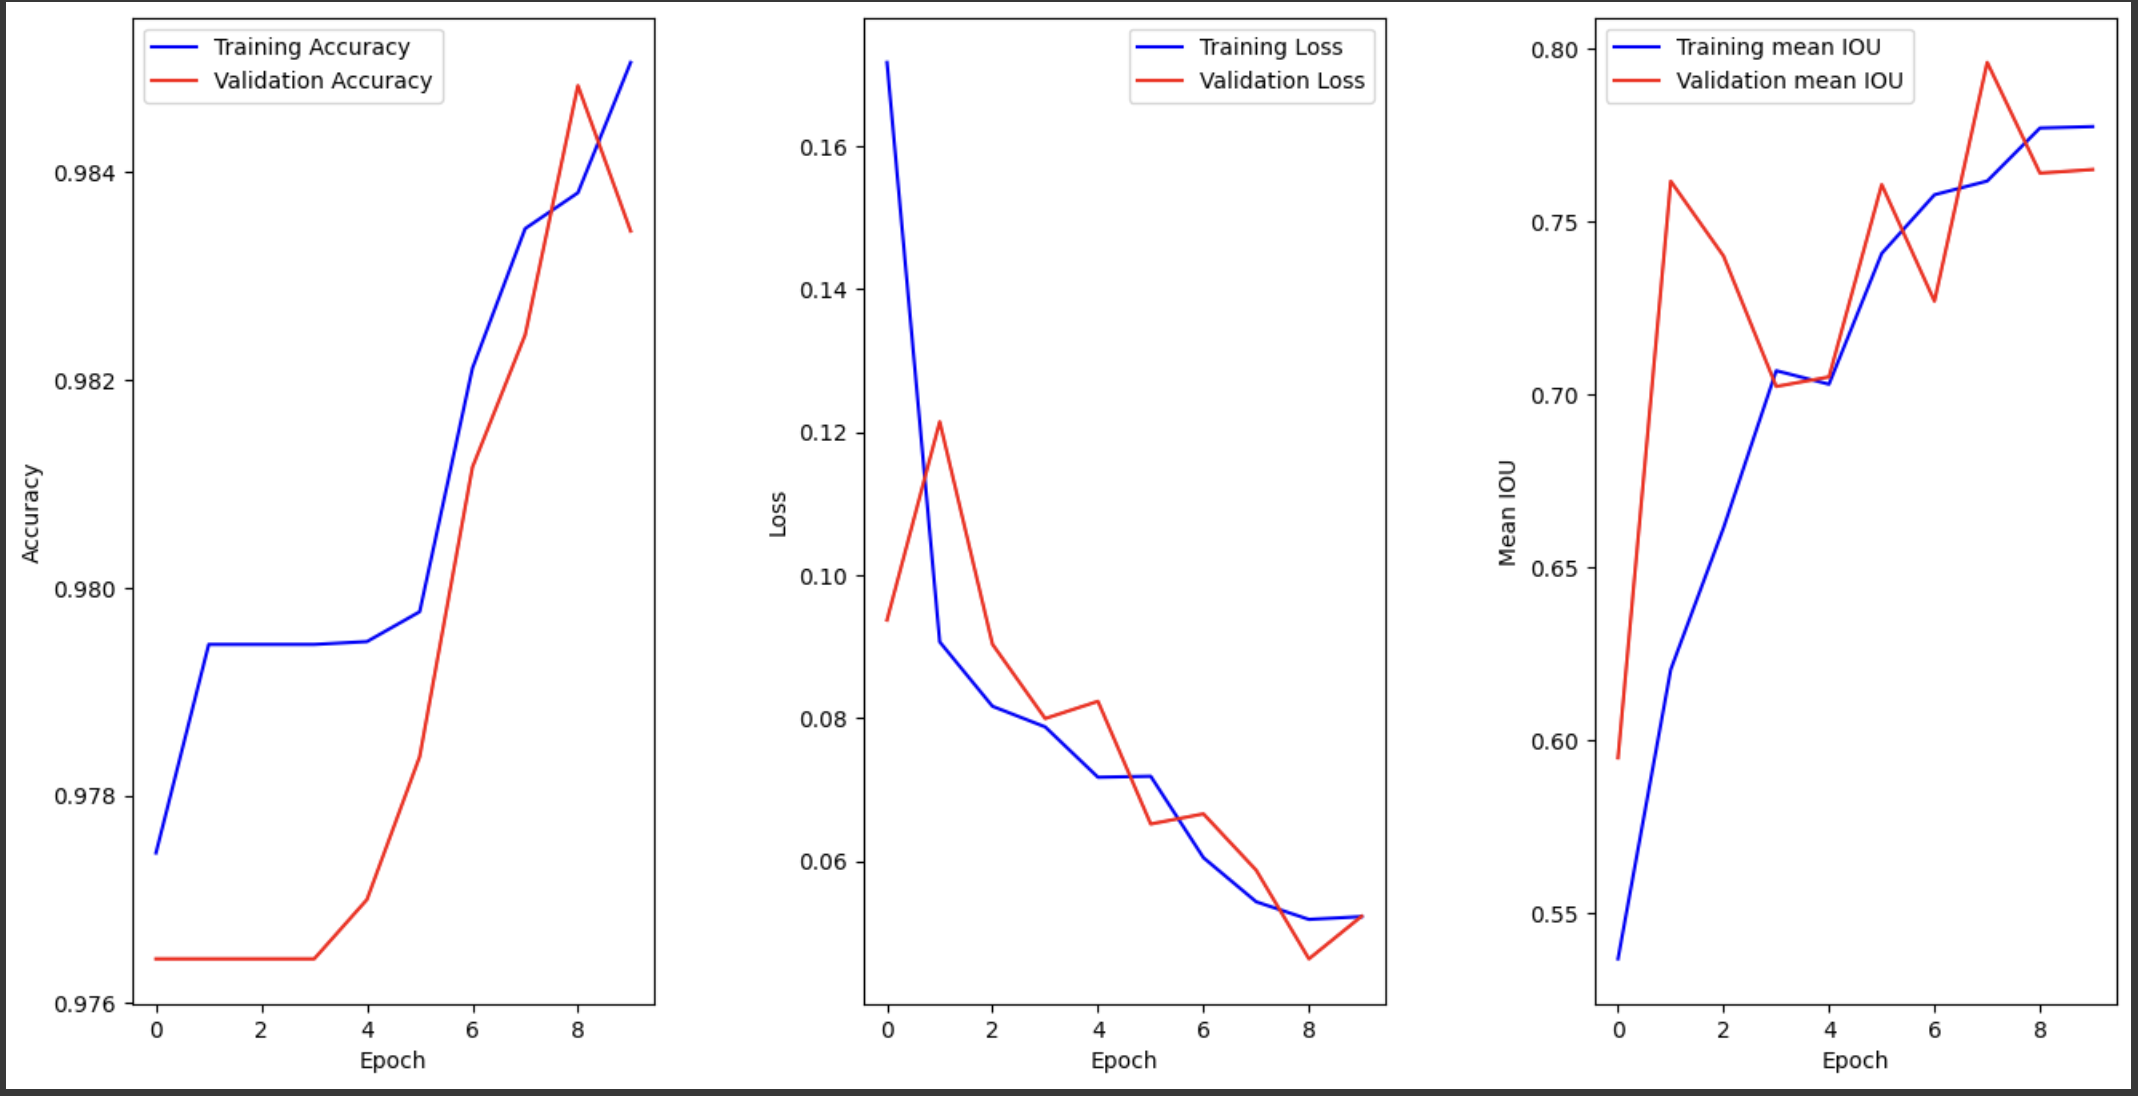


we see that both the training and validation accuracy would rise at a steady pace throughout epochs however it seems the training accuracy still need some time to stabilize, issues like overfitting are not overly prevalent here. Our loss for both sets would maintain consistency, and our Mean IOU would reinforce the model's generalization at around epochs 8-10, we could most likely increase the epoch size when training in order to get a better performing model

### Predict tumor segmentations

Given the model weights, we can now apply our model on individual casses

We will do so with this function, which predicts the segmentation of a patient in the test dataset, this will be shown in axial view, typically this would be shown in all 3 views but axial is more commonly used in practice

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # but adapted for sagittal view and keeping the same input shape
    for i in range(VOLUME_SLICES):
        # Access data in sagittal plane (x,:,:)
        X[i,:,:,0] = cv2.resize(flair[:,:,i+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[i,:,:,1] = cv2.resize(t1ce[:,:,i+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)


We will call the predict_segmentation function on variations of the 4 possible values(NT, ED, etc...) for the segmentations:

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Core + Edema + Enhancing
    zero = predicted_seg[slice_to_plot,:,:,0] # background
    first = predicted_seg[slice_to_plot,:,:,1] # Core
    second = predicted_seg[slice_to_plot,:,:,2] # Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

### Plot Random predictions & Compare with Original

2/2 [==============================] - 1s 253ms/step
Patient:  BraTS20_Training_366


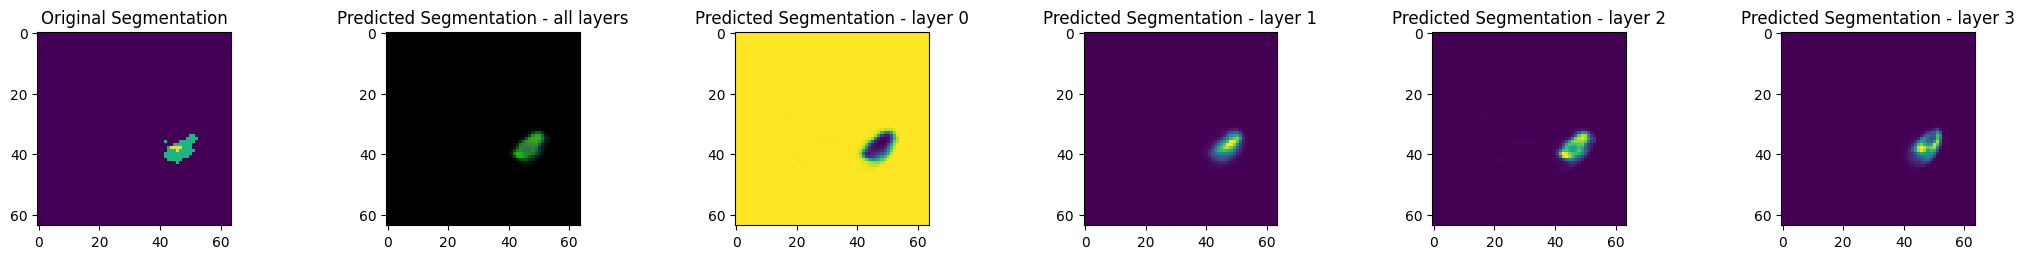

In [ ]:
show_predicted_segmentations(samples_test, 25, cmap, norm)

2/2 [==============================] - 1s 251ms/step
Patient:  BraTS20_Training_107


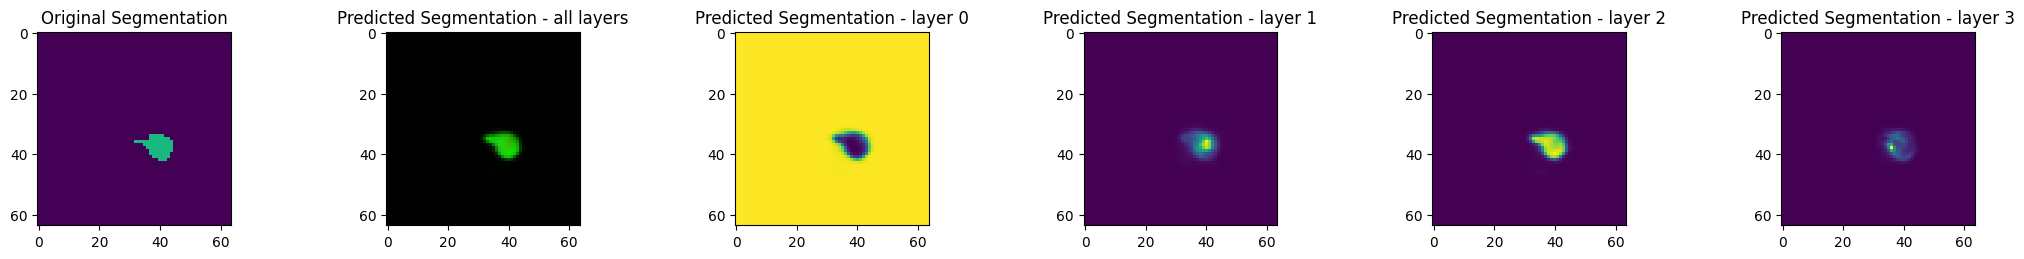

In [ ]:
show_predicted_segmentations(samples_test, 15, cmap, norm)

the predicted segmentations would be quite accurate in its analysis

Though there are cases of false positives which means that we would falsely diagnose a healthy patient with a tumor, this can be mitigated by analyzing the same patient from the other 2 views, adjusting the model to be more accurate(larger data set, adjusting hyperparameters, etc).


###Here are such instances in our sample list:

####False Positive Result:

2/2 [==============================] - 1s 258ms/step
Patient:  BraTS20_Training_257


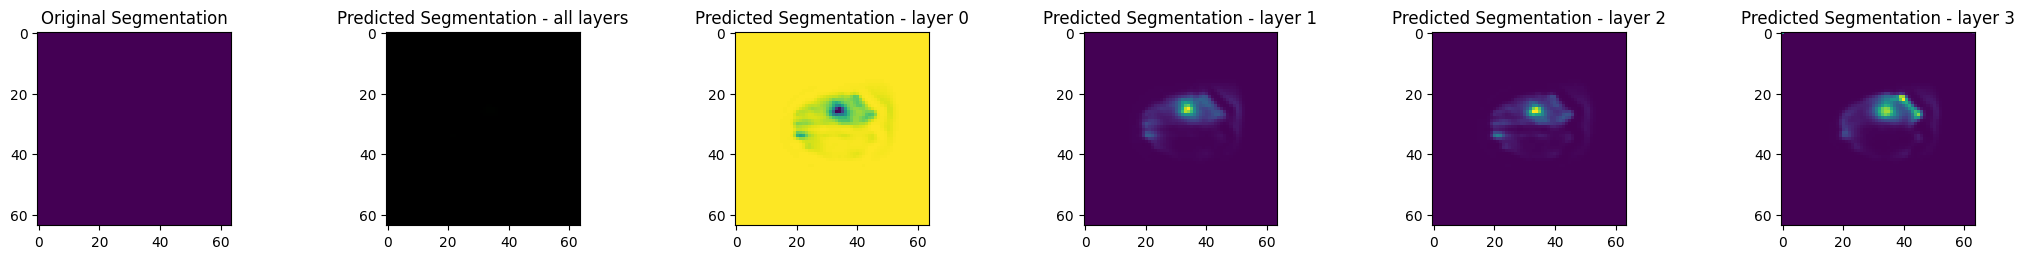

In [ ]:
show_predicted_segmentations(["BraTS20_Training_257"], 39, cmap, norm)

####True Positive Result

2/2 [==============================] - 1s 248ms/step
Patient:  BraTS20_Training_193


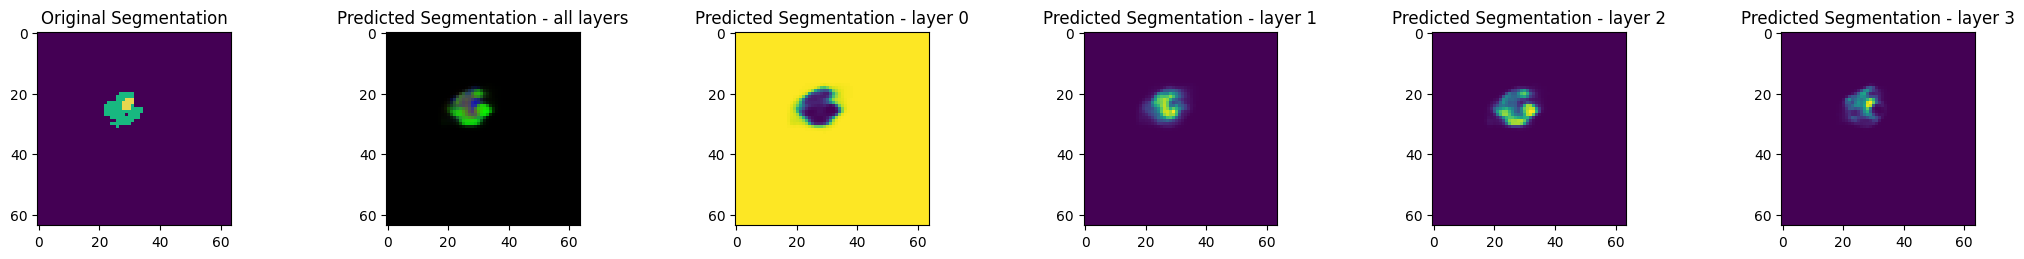

In [ ]:
show_predicted_segmentations(["BraTS20_Training_193"], 39, cmap, norm)

#### Post-processing

A way we can check for these false positives would be to implement some sort of post-processing procedure to detect the legitimacy of the output, through argmax decoding, we can do so by visualizing the original, unprocessed and processed prediction for the brain tumor segmentation model  

In [ ]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):

    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3

    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan

    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4]

    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')

    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

####False Positive Sample:

2/2 [==============================] - 3s 466ms/step
Patient number:  BraTS20_Training_257


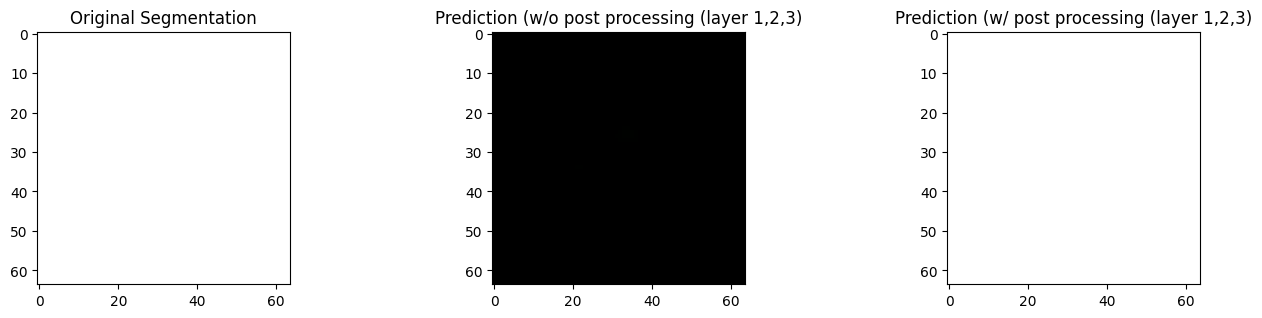

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_257", slice_to_plot=39, cmap=cmap, norm=norm)

####True Positive Sample:

2/2 [==============================] - 2s 489ms/step
Patient number:  BraTS20_Training_193


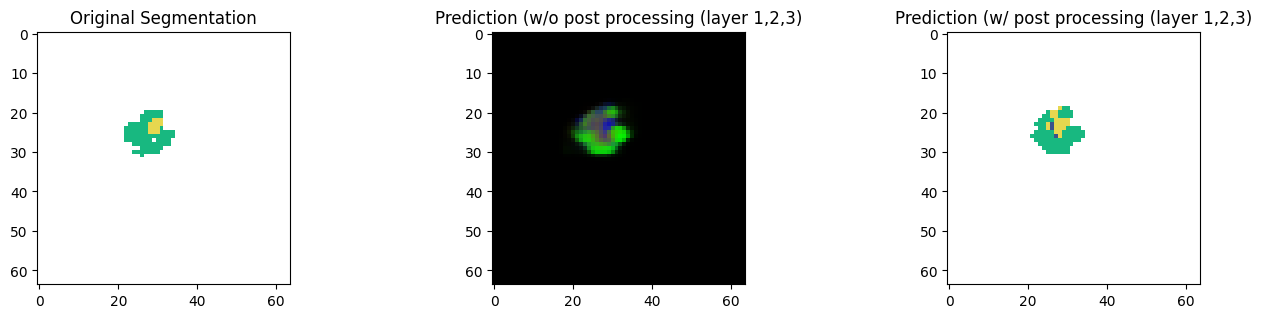

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_193", slice_to_plot=39, cmap=cmap, norm=norm)

We see now the false-positive is removed and our prediction validity is maintained.

### Evaluate the model
we call evaluate() to evaluate the performance of our model on our test dataset.

In [ ]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 [==============================] - 82s 2s/step - loss: 0.0389 - accuracy: 0.9875 - mean_io_u: 0.6718 - precision: 0.9900 - sensitivity: 0.9845 - specificity: 0.9966

Model evaluation on the test set:
Loss : 0.0389
Accuracy : 0.9875
MeanIOU : 0.6718
Precision : 0.99
Sensitivity : 0.9845
Specificity : 0.9966


### Output recieved
Model evaluation on the test set:

==================================

Loss : 0.0331

Accuracy : 0.9889

MeanIOU : 0.6603

Precision : 0.991

Sensitivity : 0.9864

Specificity : 0.997


###Conclusion
Overall, the model would perform quite well with a test loss of around 0.033 for an image segmentation task, whilst also maintaing a good generalization seen on the other metrics. This enables a quicker, more clear synopsis for tumor diagnoses